# **MedQDx - EDA & Baseline**
Dataset - [The Symptom-Disease Prediction Dataset (SDPD)](https://data.mendeley.com/datasets/dv5z3v2xyd/1)

## **EDA**

In [ ]:
!pip install pandas tqdm openai --no-cache-dir

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive, files
from openai import AzureOpenAI
import random
import re
from tqdm import tqdm
import time
import os
import requests
import subprocess
import transformers
from sklearn.model_selection import train_test_split
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,TrainingArguments,Trainer,DataCollatorWithPadding)

In [ ]:
df = pd.read_csv('/content/symbipredict_2022.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection


In [ ]:
df.shape

(4961, 133)

### **Duplicate rows**

In [ ]:
dup_mask = df.duplicated()
num_dupes = dup_mask.sum()
print(f"Found {num_dupes} duplicate row(s).")

Found 4657 duplicate row(s).


In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
print("New shape without duplicates:", df.shape)

New shape without duplicates: (304, 133)


In [ ]:
df.to_csv("df_no_dups.csv", index=False)

### **Data statistics**

In [ ]:
feature_cols = [c for c in df.columns if c != 'prognosis']
df['ones_count'] = df[feature_cols].sum(axis=1)

stats = (
     df
     .groupby('prognosis')['ones_count']
     .agg(
         n_rows='count',
         min_ones='min',
         max_ones='max',
         range_ones=lambda x: x.max() - x.min(),
         avg_ones='mean'
     ).reset_index())

stats['avg_ones'] = stats['avg_ones'].round(2)
stats

,prognosis,n_rows,min_ones,max_ones,range_ones,avg_ones
0,AIDS,5,3,4,1,3.20
1,Acne,5,3,4,1,3.20
2,Alcoholic Hepatitis,8,6,7,1,6.12
3,Allergy,5,3,4,1,3.20
4,Arthritis,6,4,5,1,4.17
5,Bronchial Asthma,7,5,6,1,5.14
6,Cervical Spondylosis,6,4,5,1,4.17
7,Chickenpox,10,10,11,1,10.10
8,Chronic Cholestasis,8,6,7,1,6.12
9,Common Cold,9,16,17,1,16.11


In [ ]:
counts = df.groupby('prognosis').size().reset_index(name='n_rows')

avg_rows = counts['n_rows'].mean()

max_idx = counts['n_rows'].idxmax()
min_idx = counts['n_rows'].idxmin()

most = counts.loc[max_idx]
fewest = counts.loc[min_idx]

print(counts)
print(f"\nAverage rows per disease: {avg_rows:.2f}")
print(f"Disease with most rows: {most['prognosis']} ({most['n_rows']} rows)")
print(f"Disease with fewest rows: {fewest['prognosis']} ({fewest['n_rows']} rows)")

                        prognosis  n_rows
0                            AIDS       5
1                            Acne       5
2             Alcoholic Hepatitis       8
3                         Allergy       5
4                       Arthritis       6
5                Bronchial Asthma       7
6            Cervical Spondylosis       6
7                      Chickenpox      10
8             Chronic Cholestasis       8
9                     Common Cold       9
10                         Dengue      10
11                      Diabetes        9
12  Dimorphic Hemmorhoids (piles)       6
13                  Drug Reaction       6
14               Fungal Infection       5
15                           GERD       7
16                Gastroenteritis       5
17                   Heart Attack       5
18                    Hepatitis A       9
19                    Hepatitis B       9
20                    Hepatitis C       7
21                    Hepatitis D      10
22                    Hepatitis E 

In [ ]:
disease_col   = 'prognosis'
symptom_cols  = [col for col in df.columns if col != disease_col]

symptom_counts = df[symptom_cols].sum()

most_common  = symptom_counts.sort_values(ascending=False)
least_common = symptom_counts.sort_values(ascending=True)

print("Top 10 most common symptoms:")
print(most_common.head(10))

print("\nTop 10 least common symptoms:")
print(least_common.head(10))


Top 10 most common symptoms:
ones_count           2077
fatigue               134
vomiting              105
loss_of_appetite       81
high_fever             81
nausea                 77
abdominal_pain         70
headache               66
yellowish_skin         61
yellowing_of_eyes      58
dtype: int64

Top 10 least common symptoms:
altered_sensorium            0
dehydration                  0
foul_smell_of urine          0
bladder_discomfort           0
weakness_of_one_body_side    0
patches_in_throat            0
muscle_wasting               0
extra_marital_contacts       0
dischromic _patches          0
pus_filled_pimples           0
dtype: int64


Dropping single-value columns

In [ ]:
single_valued = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(columns=single_valued, inplace=True)

print("Dropped columns:", single_valued)
print("New shape:", df.shape)

Dropped columns: ['fluid_overload']
New shape: (304, 133)


Distribution of diseases by number of symptoms

In [ ]:
dist = (
    df
    .groupby('ones_count')['prognosis']
    .count()
    .reset_index(name='n_diseases')
    .sort_values('ones_count'))

dist

,ones_count,n_diseases
0,3,32
1,4,38
2,5,48
3,6,28
4,7,18
5,8,20
6,9,10
7,10,42
8,11,21
9,12,17


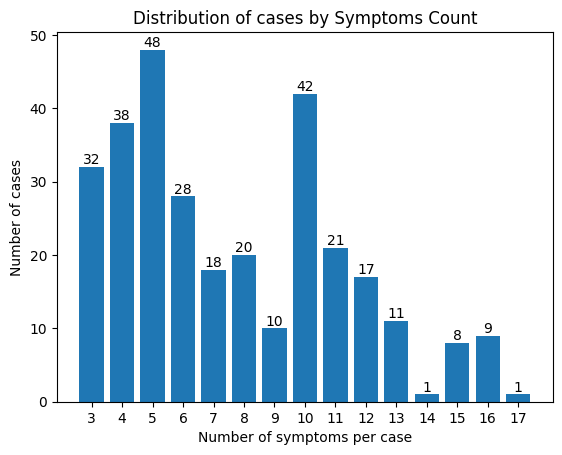

In [ ]:
plt.bar(dist['ones_count'], dist['n_diseases'])

for x, y in zip(dist['ones_count'], dist['n_diseases']):
    plt.text(x, y, str(y), ha='center', va='bottom')

plt.xlabel('Number of symptoms per case')
plt.ylabel('Number of cases')
plt.title('Distribution of cases by Symptoms Count')
plt.xticks(dist['ones_count'])
plt.show()

Keeping rows with at least 5 symptoms

In [ ]:
df = df[df['ones_count'] >= 5].reset_index(drop=True)
print("New shape:", df.shape)

New shape: (234, 133)


In [ ]:
df

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,ones_count
0,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,GERD,6
1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,GERD,5
2,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,GERD,5
3,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,GERD,5
4,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,GERD,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,0,0,0,Psoriasis,5
230,0,1,0,0,0,0,1,0,0,0,...,0,1,0,1,1,0,0,0,Psoriasis,5
231,0,1,0,0,0,0,1,0,0,0,...,0,1,1,0,1,0,0,0,Psoriasis,5
232,0,1,0,0,0,0,1,0,0,0,...,0,1,1,1,0,0,0,0,Psoriasis,5


In [ ]:
dist = (
    df
    .groupby('ones_count')['prognosis']
    .count()
    .reset_index(name='n_diseases')
    .sort_values('ones_count'))

dist

,ones_count,n_diseases
0,5,48
1,6,28
2,7,18
3,8,20
4,9,10
5,10,42
6,11,21
7,12,17
8,13,11
9,14,1


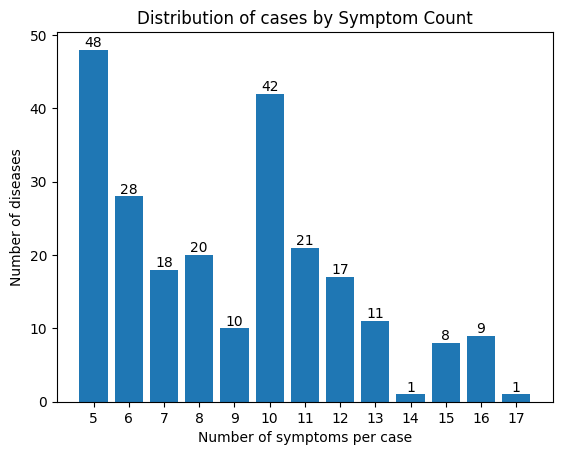

In [ ]:
plt.bar(dist['ones_count'], dist['n_diseases'])

for x, y in zip(dist['ones_count'], dist['n_diseases']):
    plt.text(x, y, str(y), ha='center', va='bottom')

plt.xlabel('Number of symptoms per case')
plt.ylabel('Number of diseases')
plt.title('Distribution of cases by Symptom Count')
plt.xticks(dist['ones_count'])
plt.show()


In [ ]:
df.to_csv("diseases_symptoms.csv", index=False)

## **Baseline**

Running the baseline for 100 random cases

In [ ]:
df_sample = df.sample(n=100, random_state=42).reset_index(drop=True)

In [ ]:
endpoint       = "MedQDx_ENDPOINT"
api_key        = "MedQDx_API_key"
api_version    = "2024-12-01-preview"
deployment     = "gpt-4o-mini"

client = AzureOpenAI(
    api_version    = api_version,
    azure_endpoint = endpoint,
    api_key        = api_key,
)

In [ ]:
def call_gpt4o_mini(symptoms: list[str]) -> dict[str, str]:
    symptom_list = ", ".join(symptoms)
    prompt = f"""You are a clinical case writer. Given the following symptoms: {symptom_list}

1. **100% Case:** Write a realistic patient‐history paragraph that includes *all* symptoms (no disease name).
2. **80% Case:** Paragraph with ~80% of the symptoms (no disease name).
3. **50% Case:** Paragraph with ~50% of the symptoms (no disease name).

**Return only** a JSON object exactly in this format (no Markdown fences, no extra text):

{{
  "full_case": "...",
  "case_80_percent": "...",
  "case_50_percent": "..."
}}
"""
    resp = client.chat.completions.create(
        model       = deployment,
        messages    = [
            {"role": "system", "content": "You are a helpful clinical case writer."},
            {"role": "user",   "content": prompt},
        ],
        temperature = 1.0,
        max_tokens  = 1024,
        top_p       = 1.0,
    )
    text = resp.choices[0].message.content.strip()

    # strip out Markdown code fences if the model still added them
    # (remove leading ```json or ``` and trailing ```)
    text = re.sub(r"^```(?:json)?\s*", "", text)
    text = re.sub(r"\s*```$", "", text)

    try:
        data = json.loads(text)
        return {
            "full_case":       data["full_case"].strip(),
            "case_80_percent": data["case_80_percent"].strip(),
            "case_50_percent": data["case_50_percent"].strip(),
        }
    except (json.JSONDecodeError, KeyError) as e:
        raise ValueError(f"Failed to parse JSON from model output: {e}\nOutput was:\n{text}")


In [ ]:
df_out = df[["prognosis"]].copy()
df_out[["symptoms", "100% Case", "80% Case", "50% Case"]] = ""

for idx, row in df.iterrows():
    prognosis = row["prognosis"]
    symptoms = [
        col for col in df_sample.columns
        if col != "prognosis" and row[col] == 1
    ]
    df_out.at[idx, "symptoms"] = ", ".join(symptoms)

    try:
        cases = call_gpt4o_mini(symptoms)
    except Exception as e:
        print(f"[Warning] row {idx} ({prognosis}): {e}")
        continue

    df_out.at[idx, "100% Case"]       = cases["full_case"]
    df_out.at[idx, "80% Case"]        = cases["case_80_percent"]
    df_out.at[idx, "50% Case"]        = cases["case_50_percent"]

    time.sleep(0.5)

df_out.to_csv("benchmark_cases100.csv", index=False)
print(df_out)

[Warning] row 64 (Malaria): Failed to parse JSON from model output: Expecting property name enclosed in double quotes: line 5 column 1 (char 1372)
Output was:
{
  "full_case": "The patient, a 32-year-old male, presented to the emergency department with a history of chills and sweating that started abruptly two days ago. He reported experiencing recurrent episodes of vomiting and nausea, accompanied by diarrhea that worsened over the last 24 hours. The patient also complained of constant headaches and generalized muscle pain, which have made it difficult for him to maintain his usual activities. He has no significant past medical history and denies any recent travel or exposure to sick individuals.",
  "case_80_percent": "The patient, a 28-year-old female, arrived at the clinic reporting a sudden onset of chills and headaches that began earlier today. She described feeling very nauseous and mentioned having a few episodes of vomiting. While she has not experienced diarrhea, she did note

# **Jaccard similarity**

In [ ]:
def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    union = len(set1.union(set2))
    if union == 0:
        return 0.0
    return len(set1.intersection(set2)) / union

def safe_split(value):
    if isinstance(value, str):
        return [s.strip() for s in value.split(',')]
    return value if isinstance(value, list) else []

def extract_symptoms(text, symptom_reference):
    if not isinstance(text, str):
        return []
    text = text.lower()
    found_symptoms = [symptom for symptom in symptom_reference if symptom.lower() in text]
    return found_symptoms

df = df_out

df[['100% Case', '80% Case', '50% Case']] = df[['100% Case', '80% Case', '50% Case']].fillna('')

df['symptoms'] = df['symptoms'].apply(safe_split)

all_symptoms = set()
df['symptoms'].apply(lambda x: all_symptoms.update(x))

df['100_case_symptoms'] = df['100% Case'].apply(lambda x: extract_symptoms(x, all_symptoms))
df['80_case_symptoms'] = df['80% Case'].apply(lambda x: extract_symptoms(x, all_symptoms))
df['50_case_symptoms'] = df['50% Case'].apply(lambda x: extract_symptoms(x, all_symptoms))

df['100_overlap'] = df.apply(lambda row: jaccard_similarity(row['symptoms'], row['100_case_symptoms']), axis=1)
df['80_overlap'] = df.apply(lambda row: jaccard_similarity(row['symptoms'], row['80_case_symptoms']), axis=1)
df['50_overlap'] = df.apply(lambda row: jaccard_similarity(row['symptoms'], row['50_case_symptoms']), axis=1)

df['gradient_valid'] = (df['100_overlap'] >= df['80_overlap']) & (df['80_overlap'] >= df['50_overlap'])

print("Evaluation Summary:")
print(f"Average Overlap: 100% Case = {df['100_overlap'].mean():.2f}, "
      f"80% Case = {df['80_overlap'].mean():.2f}, 50% Case = {df['50_overlap'].mean():.2f}")
print(f"Valid Confidence Gradient: {df['gradient_valid'].mean() * 100:.2f}% of cases")

print(df[['prognosis', 'symptoms', '100_case_symptoms', '80_case_symptoms', '50_case_symptoms',
          '100_overlap', '80_overlap', '50_overlap', 'gradient_valid']].head())

Evaluation Summary:
Average Overlap: 100% Case = 0.37, 80% Case = 0.32, 50% Case = 0.23
Valid Confidence Gradient: 91.00% of cases
             prognosis                                           symptoms  \
0           Chickenpox  [skin_rash, fatigue, lethargy, high_fever, hea...   
1         Hypoglycemia  [vomiting, fatigue, sweating, headache, nausea...   
2       Varicose Veins  [fatigue, cramps, obesity, swollen_legs, swoll...   
3  Chronic Cholestasis  [itching, yellowish_skin, nausea, loss_of_appe...   
4          Hepatitis D  [joint_pain, vomiting, fatigue, yellowish_skin...   

                                   100_case_symptoms  \
0             [malaise, lethargy, fatigue, headache]   
1  [irritability, vomiting, nausea, palpitations,...   
2                         [cramps, obesity, fatigue]   
3                                  [nausea, itching]   
4                        [vomiting, nausea, fatigue]   

                                    80_case_symptoms  \
0            